# Анализ мобильного приложения  по продаже продуктов питания

В стартапе, который продаёт продукты питания нужно разобраться, как ведут себя пользователи мобильного приложения.  

Имеется датасет с данными о логах — действиях пользователей, или событиях.   
Каждая запись в логе — это действие пользователя, или событие.   

- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Задача:**  узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
Исследовать результаты A/A/B-эксперимента по изменению шрифтов во всём приложении, выяснить, какой шрифт лучше.  

**План работы.**    

1. Загрузить данные и изучить общую информацию.  
   
   
2. Подготовить данные к анализу. 
   
   
3.  Изучить и проверить данные:  
      
    3.1. Сколько всего событий, пользователей в логе?   
    
    3.2. Сколько в среднем событий приходится на пользователя?  
    
    3.3. Данными за какой период мы располагаем? Найти максимальную и минимальную дату.  
    
    3.4. Изучить, как меняется количество данных. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Скорректировать реальный период используемых данных.  
    
    3.5. Оценить количество событий и пользователей, которых потеряли, отбросив старые данные.  
    
    3.6. Проверьте, что есть пользователи из всех трёх экспериментальных групп.
   
    
4. Изучить воронку событий:  

    4.1. Выяснить, какие события есть в логах, как часто они встречаются.  
    
    4.2. Посчитайте, сколько пользователей совершали каждое из этих событий.  
    
    4.3. Сделать предположение о порядке событий.  
    
    4.4. По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки.  
    
    4.5. На каком шаге теряется больше всего пользователей?  
    
    4.6. Какая доля пользователей доходит от первого события до оплаты?
 
 
5. Изучить результаты эксперимента:  

    5.1. Оценить количество пользователей в каждой экспериментальной группе.  
    
    5.2. Убедиться в корректности всех механизмов и расчётов эксперимента, проверив, находят ли статистические критерии разницу между выборками 246 и 247 (А/А).  
    
    5.3. Выяснить корректность разбиения на контрольные группы, проверив для каждого события, будет ли отличие между группами статистически достоверным.  
    
    5.4. Для тестовой группы сравните результаты с каждой из контрольных групп в отдельности по каждому событию, а также с объединённой контрольной группой. Сделать выводы из эксперимента.  
    
    5.5. Оценить выбранный уровень статической значимости, посчитав количество сделанных проверок статистических гипотез.
      
      
6. Сформулировать общий вывод.  

## Открытие файла с данными и изучение общей информации

In [5]:
# Импортируем библиотеки
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Загружаем данные из csv-файла в переменную logs
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [7]:
display(logs.head(), logs.tail())
logs.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


***Датасет содержит 244126 строк и 4 столбца.    
Пропусков в строках не обнаружено.   
Названия столбцов записаны с использованием заглавных букв. Приведем их к стандартному виду, изменим название последнего столбца.   
Типы данных во всех колонках соответствуют сохранённым в них значениям. Столбец `EventTimestamp` содержит дату в формате Unix epoch (временные метки, представляющие количество секунд с 1 января 1970 года). Добавим столбцы с датой и временем, и отдельный столбец с датой в формате datetime64.***  

## Предобработка данных

In [10]:
# Заменяем названия столбцов 
logs = logs.rename(
    columns={'EventName':'event_name', 'DeviceIDHash':'user_id',
             'EventTimestamp':'event_ts', 'ExpId':'group'}
)

In [11]:
# добавляем столбец с датой и временем в формате datetime64
logs['event_dt'] = pd.to_datetime(logs['event_ts'], unit='s') 
# добавляем столбец с датой
logs['date'] = logs['event_dt'].dt.date

In [12]:
# переименуем названия групп
logs['group'] = logs['group'].replace(246,'A246')
logs['group'] = logs['group'].replace(247,'A247')
logs['group'] = logs['group'].replace(248,'B248')

In [13]:
display(logs.head())

,event_name,user_id,event_ts,group,event_dt,date
0,MainScreenAppear,4575588528974610257,1564029816,A246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B248,2019-07-25 11:48:42,2019-07-25


In [14]:
# Проверим датасет на наличие дубликатов
logs.duplicated().sum()

413

In [15]:
# Процент дубликатов от основной таблицы
logs.duplicated().sum() / logs.shape[0] * 100

0.16917493425526162

In [16]:
# удаляем дубликаты
logs = logs.drop_duplicates()
logs.duplicated().sum()

0

In [17]:
# Проверим датасет на наличие неявных дубликатов,
# изучим список уникальных значений в столбце 'event_name'  
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Неявных дубликатов не обнаружено.

In [19]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_ts    243713 non-null  int64         
 3   group       243713 non-null  object        
 4   event_dt    243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.0+ MB


**Обработанный датасет содержит 243713 строк, 6 столбцов и подготовлен к работе:**   
- названия всех колонок записаны в едином стиле;  
- добавлен столбец `event_dt` с датой и временем, а также столбец с датой события `date`;  
- пропуски и дубликаты отсутствуют;  
- типы данных во всех столбцах соответствуют сохранённым в них значениям.

## Изучение и проверка данных

### Сколько всего событий, пользователей в логе? 

In [23]:
# количество событий
events = logs.shape[0] 
print(f'Всего событий в логе {events}, уникальных типов событий {logs["event_name"].nunique()}.')

Всего событий в логе 243713, уникальных типов событий 5.


In [24]:
# количество пользователей
users = logs["user_id"].nunique()
print(f'Всего уникальных пользователей в логе {users}.')

Всего уникальных пользователей в логе 7551.


###  Сколько в среднем событий приходится на пользователя?

In [26]:
print(f'Среднее количество событий на пользователя {events / users:.0f}.')

Среднее количество событий на пользователя 32.


### Данными за какой период мы располагаем? Максимальная и минимальная даты.

In [28]:
first_date = logs['event_dt'].min() # минимальная дата 
last_date = logs['event_dt'].max() # максимальная дата

print(f'Мы располагаем данными за {last_date - first_date}, c {first_date} по {last_date}.')

Мы располагаем данными за 13 days 16:31:41, c 2019-07-25 04:43:36 по 2019-08-07 21:15:17.


### Как меняется количество данных? Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Скорректировать реальный период используемых данных.

**Подготовка данных:** создадим агрегированные данные для групп по количеству событий по датам

In [31]:
# Функция для создания сводной таблицы событий по датам для указанной группы
def create_pivot_table(logs, group):
    group_logs = logs[logs['group'] == group] #срез данных по группе
    # Создаем сводную таблицу с количеством событий
    pivot_table = group_logs.pivot_table(index='date', values='event_name', aggfunc='count')
    # Меняем название столбца на более понятное
    pivot_table = pivot_table.rename(columns={'event_name': f'event_cnt_{group}'})
    # Сброс индекса, чтобы 'date' стал обычным столбцом, а не индексом
    pivot_table = pivot_table.reset_index()
    # Приводим столбец 'date' к типу datetime64[ns]
    pivot_table['date'] = pd.to_datetime(pivot_table['date'])
    return pivot_table

In [32]:
# Создадим сводные таблицы для каждой группы
events_by_date_A246 = create_pivot_table(logs, 'A246')
events_by_date_A247 = create_pivot_table(logs, 'A247')
events_by_date_B248 = create_pivot_table(logs, 'B248')

# Создадим полный диапазон дат
full_date_range = pd.date_range(start='2019-07-25', end='2019-08-07')

# Преобразуем в DataFrame
full_date_range_df = pd.DataFrame(full_date_range, columns=['date'])

# Объединим все в один DataFrame
events_by_date = full_date_range_df.merge(events_by_date_A246, on='date', how='left')\
                                   .merge(events_by_date_A247, on='date', how='left')\
                                   .merge(events_by_date_B248, on='date', how='left')
events_by_date

,date,event_cnt_A246,event_cnt_A247,event_cnt_B248
0,2019-07-25,4,1,4
1,2019-07-26,14,8,9
2,2019-07-27,24,23,8
3,2019-07-28,33,36,36
4,2019-07-29,55,58,71
5,2019-07-30,129,138,145
6,2019-07-31,620,664,746
7,2019-08-01,11561,12306,12274
8,2019-08-02,10946,10990,13618
9,2019-08-03,10575,11024,11683


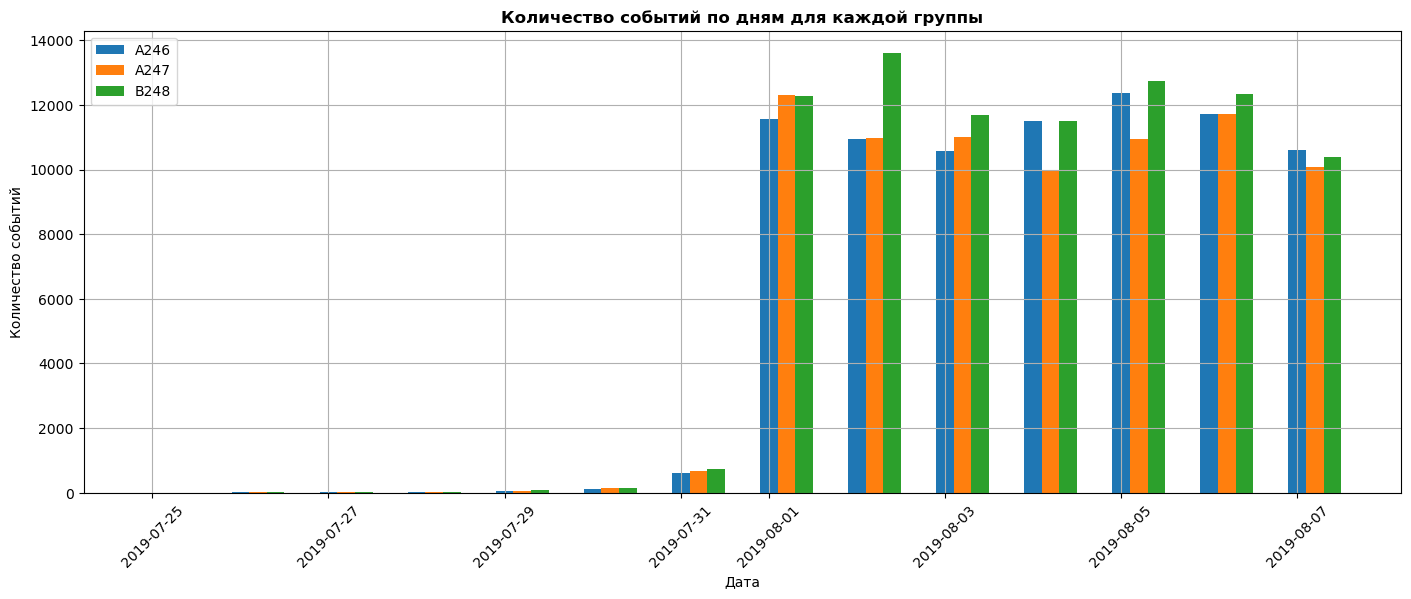

In [33]:
# Cтроим столбчатую диаграмму для оценки количество событий в зависимости от времени в разрезе групп.
plt.figure(figsize=(17,6))

plt.bar(events_by_date['date'], 
        events_by_date['event_cnt_A246'], 
        width=0.2, 
        label='A246', 
        align='center')
plt.bar(events_by_date['date'] + pd.Timedelta(days=0.2), 
        events_by_date['event_cnt_A247'], 
        width=0.2, 
        label='A247', 
        align='center')
plt.bar(events_by_date['date'] + pd.Timedelta(days=0.4), 
        events_by_date['event_cnt_B248'], 
        width=0.2, 
        label='B248', 
        align='center')

plt.title('Количество событий по дням для каждой группы', fontsize=12, fontweight="bold")
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.ylabel('Количество событий')
plt.legend(loc='upper left')
plt.grid()
plt.show()

На диаграмме видна значительная разница в количестве данных за первую и вторую половину рассматриваемого периода, Можно сделать вывод, что данные за июль неполные.  Для анализа возьмем события за полную неделю с 1 по 7 августа 2019 года. 

In [35]:
# Отбросим более старые данные (после 31 июля)
logs_aug = logs[logs['date'] > pd.to_datetime('2019-07-31').date()]

### Оценка количества событий и пользователей, которых потеряли, отбросив старые данные


In [37]:
# количество событий после изменения
events_aug = logs_aug.shape[0]

print(f'Было всего событий {events}, уникальных типов событий {logs["event_name"].nunique()}.')
print(f'Стало всего событий {events_aug}, уникальных типов событий {logs_aug["event_name"].nunique()}.')
print(f'Мы потеряли {events_aug/events:.0f}% событий, отбросив старые данные.')

Было всего событий 243713, уникальных типов событий 5.
Стало всего событий 240887, уникальных типов событий 5.
Мы потеряли 1% событий, отбросив старые данные.


In [38]:
# количество пользователей после изменения
users_aug = logs_aug["user_id"].nunique()

print(f'Было всего уникальных пользователей {users}.')
print(f'Стало всего уникальных пользователей {users_aug}.')
print(f'Мы потеряли {users_aug/users:.0f}% пользователей, отбросив старые данные.')

Было всего уникальных пользователей 7551.
Стало всего уникальных пользователей 7534.
Мы потеряли 1% пользователей, отбросив старые данные.


In [39]:
print(f'Было среднее количество событий на пользователя {events / users:.1f}.')
print(f'Стало среднее количество событий на пользователя {(events_aug / users_aug):.1f}.')

Было среднее количество событий на пользователя 32.3.
Стало среднее количество событий на пользователя 32.0.


Мы отбросили незначительную часть данных, которая не должна повлиять на результаты анализа.

### Проверка, что есть пользователи из всех трёх экспериментальных групп

In [42]:
logs_aug.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A246,2484
A247,2513
B248,2537


В обновленном датасете есть пользователи из всех трех экспериментальных групп

***Первоначальные данные были за две недели, c 2019-07-25 по 2019-08-07. Проверка показала, что данные за июль неполные.   
Для анализа возьмем события за полную неделю с 1 по 7 августа 2019 года, отбросив 1% как событий, так и пользователей.  
В среднем получилось 32 события на пользователя. В обновленном датасете есть пользователи из всех трех экспериментальных групп.***

## Изучение воронки событий

### Исследование событий в логах, как часто они встречаются

In [47]:
event_count = logs_aug.groupby('event_name').agg({'user_id': 'count'})\
    .rename(columns={'user_id': 'events_cnt'})\
    .sort_values(by='events_cnt', ascending=False)
event_count['events_percent'] = event_count['events_cnt'] / events_aug 
event_count.style.format({'events_percent': '{:.1%}'})

,events_cnt,events_percent
event_name,,
MainScreenAppear,117328,48.7%
OffersScreenAppear,46333,19.2%
CartScreenAppear,42303,17.6%
PaymentScreenSuccessful,33918,14.1%
Tutorial,1005,0.4%


Всего 5 типов событий в логах:  
    - `MainScreenAppear` (главный экран) - пользователь открыл главный экран приложения (48.7% всех действий в приложении);  
    - `OffersScreenAppear` (предложение товаров) - пользователь перешел на экран с предложениями товаров (19.2%, меньше половины случаев просмотра главного экрана приложения переходят к экрану с предложениями товаров);  
    - `CartScreenAppear` (корзина) - пользователь добавляет товары в корзину и переходит к ее просмотру (17.6%всех событий - добавление товара в корзину);  
    - `PaymentScreenSuccessful` (оплата товара) - пользователь успешно завершил оплату (14.1% всех событий - оплата товара);  
    - `Tutorial` (инструкция) - пользователь просмотрел инструкцию (менее 1% всех событий - просмотр инструкции по пользованию приложением).

### Расчет количества пользователей, совершавших каждое из событий

In [50]:
user_count = logs_aug.groupby('event_name').agg({'user_id': 'nunique'})\
    .rename(columns={'user_id': 'users_cnt'})\
    .sort_values(by='users_cnt', ascending=False)
# Добавляем столбец с процентом уникальных пользователей от общего количества уникальных пользователей 
user_count['total_percent'] = (user_count['users_cnt'] / users_aug)
user_count.style.format({'total_percent': '{:.1%}'})

,users_cnt,total_percent
event_name,,
MainScreenAppear,7419,98.5%
OffersScreenAppear,4593,61.0%
CartScreenAppear,3734,49.6%
PaymentScreenSuccessful,3539,47.0%
Tutorial,840,11.1%


Не все пользователи открывали главный экран приложения (98.5%). Вероятно некоторые пользователи (1.5%) сразу перешли к другим этапам. Посмотрим, какие события совершали пользователи, пропустившие главный экран приложения.

In [52]:
logs_aug.query('event_name != "MainScreenAppear"')\
    .groupby(['user_id', 'event_name']).agg({'user_id': 'count'}).head(20)

user_id
user_id           event_name                      
6909561520679493  CartScreenAppear               1
                  OffersScreenAppear             1
                  PaymentScreenSuccessful        1
6922444491712477  CartScreenAppear               8
                  OffersScreenAppear            12
                  PaymentScreenSuccessful        8
7702139951469979  CartScreenAppear               5
                  OffersScreenAppear            87
                  PaymentScreenSuccessful        5
8486814028069281  CartScreenAppear               4
                  OffersScreenAppear             2
8740973466195562  OffersScreenAppear             1
9841258664663090  CartScreenAppear               8
                  OffersScreenAppear             8
                  PaymentScreenSuccessful        2
                  Tutorial                       1
12692216027168046 OffersScreenAppear             3
15708180189885246 CartScreenAppear              38
                  OffersScreenAppear            38
                  PaymentScreenSuccessful       23

In [53]:
print(users_aug - user_count['users_cnt'].iloc[0], 'уникальных пользователей пропустили главный экран.')

115 уникальных пользователей пропустили главный экран.


Некоторые пользователи действительно минуя главный экран перешли к другим этапам, видимо по прямым ссылкам. Возможность прямого перехода есть для каждой страницы.  
Инструкцию открывали 11.1% пользователей, причем этот этап не является частью воронки событий, т.к. на него переходят не последовательно, а с любого этапа. 

### Предположение о порядке событий

Событие Tutorial составляет всего 0.4% всех событий. Его можно не учитывать.   
Построим диаграммы количества событий в логах без Tutorial и количества уникальных пользователей по типам событий.

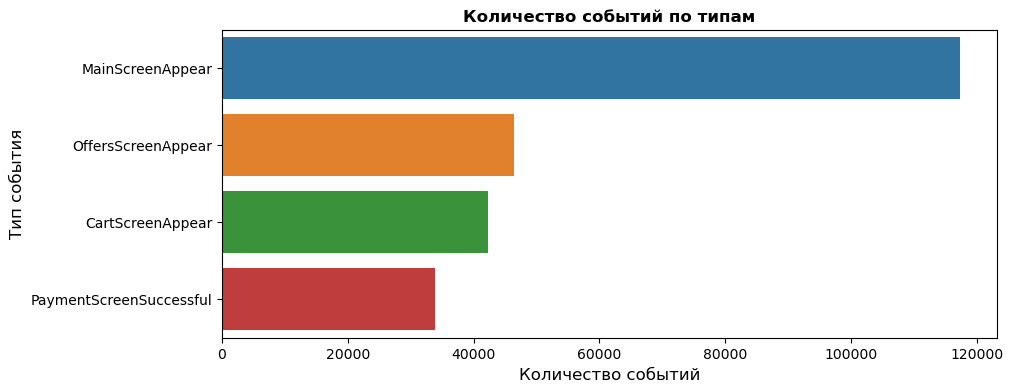

In [57]:
# Отбираем первые четыре строки таблицы event_count и только столбец users_cnt
event_funnel = event_count.iloc[:-1][['events_cnt']]

# Построим диаграмму по количеству событий для основных 4 этапов воронки событий
plt.figure (figsize=(10,4))

# Создаем горизонтальный столбчатый график
sns.barplot(x=event_funnel['events_cnt'], y=event_funnel.index, orient='h')

plt.title('Количество событий по типам', fontsize=12, fontweight="bold")
plt.xlabel('Количество событий', fontsize=12)
plt.ylabel('Тип события', fontsize=12)
plt.show()

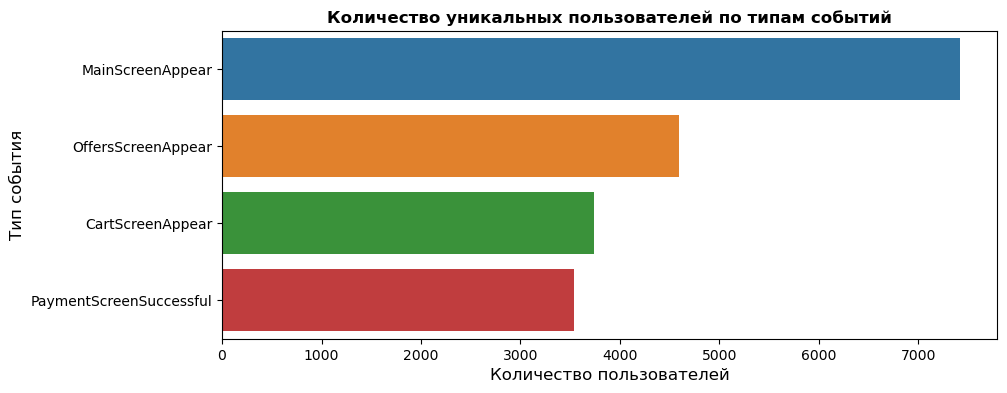

In [58]:
# Отбираем первые четыре строки таблицы user_count и только столбец users_cnt
user_funnel = user_count.iloc[:-1][['users_cnt']]

# Построим диаграмму по количеству уникальных пользователей для основных 4 этапов воронки событий
plt.figure(figsize=(10,4))

# Создаем горизонтальный столбчатый график
sns.barplot(x=user_funnel['users_cnt'], y=user_funnel.index, orient='h')

plt.title('Количество уникальных пользователей по типам событий', fontsize=12, fontweight="bold")
plt.xlabel('Количество пользователей', fontsize=12)
plt.ylabel('Тип события', fontsize=12)
plt.show()

Логично предположить, что последовательность событий идет по убыванию количества событий и пользователей на каждом этапе.  

**Воронка событий**   
1. `MainScreenAppear` (главный экран)  
2. `OffersScreenAppear` (предложение товаров) 
3. `CartScreenAppear` (корзина) 
4. `PaymentScreenSuccessful` (оплата товара)

### Расчет доли пользователей, проходящих на следующий шаг воронки

In [61]:
# Добавляем столбец CR-конверсия (доля уникальных пользователей от пользователей на первом этапе) 
user_funnel['CR'] = user_funnel['users_cnt'] / user_funnel['users_cnt'].iloc[0]

# Добавляем столбец CR_step - конверсия в шаг 
# (доля уникальных пользователей от пользователей на предыдущем этапе) 
# shift(1) сдвигает значения на одну строку вниз
user_funnel['CR_step'] = user_funnel['users_cnt'] / user_funnel['users_cnt'].shift(1) 
# Замена NaN (которые появляются из-за деления на пустое значение в первой строке) на 1
user_funnel['CR_step'].fillna(1, inplace=True)

# Форматируем значения в проценты
user_funnel_format = user_funnel.style.format({'CR': '{:.1%}', 'CR_step': '{:.1%}'})
user_funnel_format

,users_cnt,CR,CR_step
event_name,,,
MainScreenAppear,7419,100.0%,100.0%
OffersScreenAppear,4593,61.9%,61.9%
CartScreenAppear,3734,50.3%,81.3%
PaymentScreenSuccessful,3539,47.7%,94.8%


### На каком шаге теряется больше всего пользователей?

In [63]:
# Добавляем столбцы потерь и процентных потерь
user_funnel['loss'] = user_funnel['users_cnt'].iloc[0] - user_funnel['users_cnt']
user_funnel['loss_step'] = user_funnel['users_cnt'].shift(1) - user_funnel['users_cnt']

user_funnel['loss_percent_CR'] = user_funnel['loss'] / user_funnel['users_cnt'].iloc[0]
user_funnel['loss_percent_CR_step'] = user_funnel['loss_step'] / user_funnel['users_cnt'].shift(1)
user_funnel['loss_percent_CR_step'].fillna(0, inplace=True)

# Форматируем значения
user_funnel_format = user_funnel.style.format({
    'CR': '{:.1%}',
    'CR_step': '{:.1%}',
    'loss': '{:.0f}',
    'loss_step': '{:.0f}',
    'loss_percent_CR': '{:.1%}',
    'loss_percent_CR_step': '{:.1%}'
})

user_funnel_format

,users_cnt,CR,CR_step,loss,loss_step,loss_percent_CR,loss_percent_CR_step
event_name,,,,,,,
MainScreenAppear,7419,100.0%,100.0%,0,nan,0.0%,0.0%
OffersScreenAppear,4593,61.9%,61.9%,2826,2826,38.1%,38.1%
CartScreenAppear,3734,50.3%,81.3%,3685,859,49.7%,18.7%
PaymentScreenSuccessful,3539,47.7%,94.8%,3880,195,52.3%,5.2%


Почти 38% пользователей теряются на первом шаге, т.е. не идут дальше главной страницы приложения.

### Какая доля пользователей доходит от первого события до оплаты?

47.7% всех пользователей доходят до оплаты товара. (п.4.2) 
Если пользователь перешел к просмотру карточки товара, то 81.3% из них переходят на этап корзины и 94.8% переходят от корзины к оплате товара. 

**Вывод:** ***Всего в логах 5 типов событий, из которых почти половина - просмотр главной страницы. 
Не все пользователи открывали главный экран приложения. 1.5% сразу перешли к другим этапам по прямым ссылкам. Возможность прямого перехода есть для каждой страницы.
Просмотр инструкции Tutorial составляет всего 0.4% всех событий. Инструкцию открывали 11.1% пользователей, причем этот этап не является частью воронки событий, т.к. на него переходят не последовательно, а с любого этапа. Его можно не учитывать.    
Воронка событий состоит из четырех этапов: главный экран, предложение товаров, корзина, оплата товара.  
Больше всего пользователей теряются на первом шаге. Значительная часть пользователей, которые перешли к просмотру карточки товара, переходят на этап корзины и к оплате.   
Стоит доработать страницу главного экрана.***  

## Изучение результатов эксперимента

### Оценка количества пользователей в каждой экспериментальной группе

In [70]:
user_group = logs_aug.groupby('group').agg({'user_id': 'nunique'})\
    .rename(columns={'user_id': 'user_cnt'}).reset_index()
user_group['user_percent'] = round(user_group['user_cnt'] / users_aug * 100, 1)
user_group

,group,user_cnt,user_percent
0,A246,2484,33.0
1,A247,2513,33.4
2,B248,2537,33.7


В обновленном датасете распределение пользователей по группам почти равномерное, отличие не более, чем на 1%.   

Проверим, есть ли пользователи, оказавшиеся одновременно в двух группах.

In [72]:
# Разделим данные таблицы logs_aug на группы, оставим события, входящие в воронку событий
logs_aug_A246 = logs_aug[(logs_aug['group'] == 'A246') & (logs_aug['event_name'] != 'Tutorial')]
logs_aug_A247 = logs_aug[(logs_aug['group'] == 'A247') & (logs_aug['event_name'] != 'Tutorial')]
logs_aug_B248 = logs_aug[(logs_aug['group'] == 'B248') & (logs_aug['event_name'] != 'Tutorial')]

In [73]:
# Выбираем пользователей, попавших в обе группы попарно
print('Количество пользователей, попавших в обе группы A246 и A247:', 
      pd.merge(logs_aug_A246, logs_aug_A247, on='user_id', how='inner')['user_id'].unique().shape[0]) 
print('Количество пользователей, попавших в обе группы A246 и B248:', 
      pd.merge(logs_aug_A246, logs_aug_B248, on='user_id', how='inner')['user_id'].unique().shape[0])
print('Количество пользователей, попавших в обе группы A247 и B248:', 
      pd.merge(logs_aug_A247, logs_aug_B248, on='user_id', how='inner')['user_id'].unique().shape[0])

Количество пользователей, попавших в обе группы A246 и A247: 0
Количество пользователей, попавших в обе группы A246 и B248: 0
Количество пользователей, попавших в обе группы A247 и B248: 0


***В рассматирваемом датасете есть пользователи из всех трех экспериментальных групп, распределение по группам равномерное, пересечений нет.***

### Подтверждение корректности всех механизмов и расчётов эксперимента (проверка, находят ли статистические критерии разницу между выборками 246 и 247)

*Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.*

**Критерии успешного A/A-теста:**
- Количество пользователей в группах различается не более чем на 1% - ***выполнено***, отличие на 0,4%
- Для всех групп фиксируются и отправляются в системы аналитики одни и те же показатели - ***выполнено***
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости - ***требует проверки***
- Попавший в одну из групп посетитель остаётся в ней до конца теста - ***выполнено*** в п.5.1., пересечений групп нет

Примем уровень статистической значимости 5%

In [78]:
# воронка событий по группам
funnel = (logs_aug.pivot_table(index = 'event_name', columns='group', values='user_id', aggfunc='nunique')
          .query('event_name != "Tutorial"')
          .reset_index())
# добавляем столбец с общим количеством пользователей
funnel['total'] = funnel['A246']+funnel['A247']+funnel['B248']
funnel = funnel.sort_values('total', ascending=False)
funnel = funnel.reset_index(drop=True) 
funnel 

group,event_name,A246,A247,B248,total
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539


Для каждого типа событий сравним процент уникальных пользователей на каждом этапе от общего количества пользователей по группам 

In [80]:
funnel_total = funnel.copy()
# добавляем столбцы с процентом уникальных пользователей от общего количества пользователей по группам
funnel_total['total_percent_A246'] = round(funnel_total['A246'] / user_group.loc[0,'user_cnt'] * 100, 1)
funnel_total['total_percent_A247'] = round(funnel_total['A247'] / user_group.loc[1,'user_cnt'] * 100, 1)
funnel_total['total_percent_B248'] = round(funnel_total['B248'] / user_group.loc[2,'user_cnt'] * 100, 1)

# Добавляем столбец difference с разницей в долях для групп А
funnel_total['difference AA'] = funnel_total['total_percent_A246'] - funnel_total['total_percent_A247']

funnel_total.T

,0,1,2,3
group,,,,
event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
A246,2450,1542,1266,1200
A247,2476,1520,1238,1158
B248,2493,1531,1230,1181
total,7419,4593,3734,3539
total_percent_A246,98.6,62.1,51.0,48.3
total_percent_A247,98.5,60.5,49.3,46.1
total_percent_B248,98.3,60.3,48.5,46.6
difference AA,0.1,1.6,1.7,2.2


Разница в доляx пользователей от общего количества пользователей по группам А246 и А247 не превышает 1% только для главного экрана. Для остальных этапов разница от 1.6% до 2.2%, приемлимая при уровне статистической значимости 5%.

Посчитаем конверсию `CR` и конверсию в шаг `CR_step` для выборок А246 и А247.

In [83]:
# Уберем из funnel столбцы с процентами
funnel_cr = funnel.copy()

# Добавляем столбцы CR (в процентах) для групп
funnel_cr['CR_A246'] = round(funnel_cr['A246'] / funnel_cr['A246'].iloc[0] * 100, 1)
funnel_cr['CR_A247'] = round(funnel_cr['A247'] / funnel_cr['A247'].iloc[0] * 100, 1)
funnel_cr['CR_B248'] = round(funnel_cr['B248'] / funnel_cr['B248'].iloc[0] * 100, 1)

# Добавляем столбец CR_step (в процентах)
funnel_cr['CR_step_A246'] = round(funnel_cr['A246'] / funnel_cr['A246'].shift(1) * 100, 1)
funnel_cr['CR_step_A247'] = round(funnel_cr['A247'] / funnel_cr['A247'].shift(1) * 100, 1)
funnel_cr['CR_step_B248'] = round(funnel_cr['B248'] / funnel_cr['B248'].shift(1) * 100, 1)
# Замена NaN,которые появляются из-за деления на пустое значение в первой строке
funnel_cr['CR_step_A246'].fillna(100, inplace=True)
funnel_cr['CR_step_A247'].fillna(100, inplace=True)
funnel_cr['CR_step_B248'].fillna(100, inplace=True)

# Добавляем столбцы СR_dif_AA и CR_step_dif_AA с разницей 
funnel_cr['СR_dif_AA'] = funnel_cr['CR_A246'] - funnel_cr['CR_A247']
funnel_cr['СR_step_dif_AA'] = funnel_cr['CR_step_A246'] - funnel_cr['CR_step_A247']

funnel_cr[['event_name','CR_A246', 'CR_A247', 'CR_B248', 
           'CR_step_A246', 'CR_step_A247', 'CR_step_B248', 'СR_dif_AA', 'СR_step_dif_AA']].T

,0,1,2,3
group,,,,
event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
CR_A246,100.0,62.9,51.7,49.0
CR_A247,100.0,61.4,50.0,46.8
CR_B248,100.0,61.4,49.3,47.4
CR_step_A246,100.0,62.9,82.1,94.8
CR_step_A247,100.0,61.4,81.4,93.5
CR_step_B248,100.0,61.4,80.3,96.0
СR_dif_AA,0.0,1.5,1.7,2.2
СR_step_dif_AA,0.0,1.5,0.7,1.3


Различие конверсии по группам не превышает 1% только на первом шаге - просмотр главного экрана. На остальных этапах различие конверсии в пределах 2.2%, приемлимое при уровне статистической значимости 5%.  

Различие конверсии в шаг по группам менее 1% на этапе главного экрана и корзины. На остальных этапах различие конверсии в шаг не превышает 1.5%, приемлимое при уровне статистической значимости 5%.

***Разбиение на контрольные группы не идеальное, но приемлимое. Можно считать, что различий между группами А246 и А247 нет.***

### Проверка корректности разбиения на контрольные группы (проверка для каждого события, будет ли отличие между группами статистически достоверным)

*Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?*

In [88]:
funnel_total.head(1)

group,event_name,A246,A247,B248,total,total_percent_A246,total_percent_A247,total_percent_B248,difference AA
0,MainScreenAppear,2450,2476,2493,7419,98.6,98.5,98.3,0.1


Самое популярное событие `MainScreenAppear` - просмотр главного экрана. В группе А246 это событие совершили 2450 пользователей (98.7%), в группе А247 2476 пользователей (98.6%). Различие в долях 0.1%.

Для сравнения процентных метрик всегда ***используется Z-test*** для пропорций.

In [91]:
display(funnel, user_group)

group,event_name,A246,A247,B248,total
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539


,group,user_cnt,user_percent
0,A246,2484,33.0
1,A247,2513,33.4
2,B248,2537,33.7


**Сформулируем гипотезы:**
- **Н0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы;**
- **Н1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.**  

**alpha = 0.05**

In [93]:
# функция для проверки гипотезы о равенстве долей
    # array - элемент массива событий (рассматриваемый этап воронки событий);
    # trials - испытания (количество уникальных пользователей в рассматриваемой группе) 
    # column1 - группа 1
    # column2 - группа 2 
    # alpha - критический уровень статистической значимости      
def z_test(array, trials, column1, column2, alpha):
    
    for i in funnel.index:
        successes = np.array([array.loc[i, column1], array.loc[i, column2]])
                
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]
        
        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1]
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        
        # разница пропорций в датасетах
        difference = p1 - p2  
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)        
        p_value = (1 - distr.cdf(abs(z_value))) * 2   
                
        print('{} p-значение: {}'.format(funnel['event_name'][i], p_value))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('--------')

**А/А тест** для групп А246 и А247

In [95]:
trials = np.array([user_group.loc[0, 'user_cnt'], user_group.loc[1, 'user_cnt']])
z_test(funnel, trials, 'A246', 'A247', 0.05) 

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Не получилось отвергнуть нулевую гипотезу для всех этапов воронки событий, нет оснований считать доли групп А246 и А247 разными. Разбиение на группы работает корректно.*** 

### Сравнение результатов тестовой группы с каждой из контрольных групп в отдельности по каждому событию, а также с объединённой контрольной группой. Выводы из эксперимента.

*Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?*

**А/В тест** для групп А246 и В248

In [100]:
trials = np.array([user_group.loc[0, 'user_cnt'], user_group.loc[2, 'user_cnt']])
z_test(funnel, trials, 'A246', 'B248', 0.05) 

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А246 и В248 разными.***

**А/В тест** для групп А247 и В248

In [103]:
trials = np.array([user_group.loc[1, 'user_cnt'], user_group.loc[2, 'user_cnt']])
z_test(funnel, trials, 'A247', 'B248', 0.05) 

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А247 и В248 разными.***

**АА/В тест** для групп А246+А247 и В248

In [106]:
funnelAA = funnel.copy()
funnelAA['A246+A247'] = funnel['A246'] + funnel['A247'] 
funnelAA[['event_name', 'A246+A247', 'B248']]

group,event_name,A246+A247,B248
0,MainScreenAppear,4926,2493
1,OffersScreenAppear,3062,1531
2,CartScreenAppear,2504,1230
3,PaymentScreenSuccessful,2358,1181


In [107]:
# Копия таблицы user_group без последнего столбца
user_groupAA = user_group[['group', 'user_cnt']].copy()

# Создаем новую строку в виде DataFrame
sum_AA = pd.DataFrame(
    {'group': ['A246+A247'], 
     'user_cnt': [user_groupAA.loc[0, 'user_cnt'] + user_groupAA.loc[1, 'user_cnt']]})

# Добавляем новую строку к таблице с помощью concat
user_groupAA = pd.concat([user_groupAA, sum_AA], ignore_index=True)
user_groupAA

,group,user_cnt
0,A246,2484
1,A247,2513
2,B248,2537
3,A246+A247,4997


In [108]:
trials = np.array([user_groupAA.loc[3, 'user_cnt'], user_group.loc[2, 'user_cnt']])
z_test(funnelAA, trials, 'A246+A247', 'B248', 0.05) 

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А246+A247 и В248 разными.***

**Вывод:**  
***По результатам проведенных статистических тестов нельзя сделать вывод о том, какой шрифт лучше, т.к. нет оснований считать разными доли пользователей на каждом этапе воронки событий в каждой тестируемой группе.***

### Оценка выбранного уровня статической значимости

*Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.*

При проверке статистических гипотез был выбран уровень значимости 0.05 (5%)  
Было проведено всего 16 проверок статистических гипотез: 4 А/А теста и 12 А/В тестов.  

Требуется коррекция уровня значимости α.   
Применим поправку Бонферрони для расчета скорректированного уровня значимости и FWER (вероятности совершить хотя бы одну ошибку при проверке гипотез).

In [115]:
# подготавливаем данные
m = 16 # число тестов
alpha = 0.05 # исходный уровень значимости

fwer = 1 - (1 - alpha) ** m # считаем FWER при исходном уровне значимости

# считаем поправку 
alpha_bonf = alpha / m 

# считаем FWER
fwer_bonf = 1 - (1 - alpha_bonf) ** m  

print(f'При alpha = {alpha} fwer = {fwer} \nalpha_bonf = {alpha_bonf} \nfwer_bonf = {fwer_bonf}')

При alpha = 0.05 fwer = 0.5598733313482347 
alpha_bonf = 0.003125 
fwer_bonf = 0.048845042569365726


Вероятность совершить ошибку 1 рода в проведенных тестах составляет 56%.  
Чтобы снизить вероятность ошибки 1 рода до 4.9% проверим гипотезы с alpha_bonf = 0.003

**Гипотезы:**
- **Н0 - нет статистически значимой разницы между долями в группах;**
- **Н1 - статистически значимая разница между долями есть.**  
  
**alpha = 0.003**

**А/А тест с поправкой Бонферрони** для групп А246 и А247

In [120]:
trials = np.array([user_group.loc[0, 'user_cnt'], user_group.loc[1, 'user_cnt']])
z_test(funnel, trials, 'A246', 'A247', 0.003) 

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А246 и А247 разными.***

**А/В тест с поправкой Бонферрони** для групп А246 и В248

In [123]:
trials = np.array([user_group.loc[0, 'user_cnt'], user_group.loc[2, 'user_cnt']])
z_test(funnel, trials, 'A246', 'B248', 0.003) 

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А246 и В248 разными.***

**А/В тест с поправкой Бонферрони** для групп А247 и В248

In [126]:
trials = np.array([user_group.loc[1, 'user_cnt'], user_group.loc[2, 'user_cnt']])
z_test(funnel, trials, 'A247', 'B248', 0.003) 

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А247 и В248 разными.***

**АА/В тест с поправкой Бонферрони** для групп А246+А247 и В248

In [129]:
trials = np.array([user_groupAA.loc[3, 'user_cnt'], user_group.loc[2, 'user_cnt']])
z_test(funnelAA, trials, 'A246+A247', 'B248', 0.003) 

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------
PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------


***Нет оснований считать доли групп А246+A247 и В248 разными.***

**Вывод:**  
***После проведения теста с поправкой Бенферрони результат не изменился.***

## Общий вывод

Первоначальные данные были за две недели, c 2019-07-25 по 2019-08-07. Проверка показала, что данные за июль неполные.
**Для анализа взяли события за полную неделю с 1 по 7 августа 2019 года**, отбросив 1% событий и 1% пользователей. 
В среднем получилось 32 события на пользователя.     

Всего в логах 5 типов событий, из которых почти половина - просмотр главной страницы. Не все пользователи открывали главный экран приложения. 1.5% сразу перешли к другим этапам по прямым ссылкам. Возможность прямого перехода есть для каждой страницы.    
Просмотр инструкции Tutorial составляет всего 0.4% всех событий. Инструкцию открывали 11.1% пользователей, причем этот этап не является частью воронки событий, т.к. на него переходят не последовательно, а с любого этапа. 
  
**Воронка событий** состоит из четырех этапов: главный экран, предложение товаров, корзина, оплата товара.
  
**Больше всего пользователей (38%) теряются на первом шаге, т.е. не идут дальше главной страницы приложения. 47.7% от общего количества пользователей доходят до оплаты товара.  
Если пользователь перешел к просмотру карточки товара, то 81.3% из них переходят на этап корзины и 94.8% переходят от корзины к оплате товара.**  

При изучении результатов **А/А/В теста** была проведена оценка количества пользователей в каждой экспериментальной группе.   
**В рассматирваемом датасете есть пользователи из всех трех групп, распределение по группам равномерное, пересечений нет.**
  
Различие конверсии по группам не превышает 1% только на первом шаге - просмотр главного экрана. На остальных этапах различие конверсии в пределах 2.2%, приемлимое при уровне статистической значимости 5%.
Различие конверсии в шаг по группам менее 1% на этапе главного экрана и корзины. На остальных этапах различие конверсии в шаг не превышает 1.5%, приемлимое при уровне статистической значимости 5%.
**Разбиение на контрольные группы не идеальное, но приемлимое.**   
  
Для сравнения процентных метрик использовали **Z-test** для пропорций.

**Гипотезы:  
Н0 - нет статистически значимой разницы между долями в группах;  
Н1 - статистически значимая разница между долями есть.**

Проверка показала, что разбиение на группы работает корректно.

**По результатам проведенных статистических тестов нельзя сделать вывод о том, какой шрифт лучше, т.к. нет оснований считать разными доли пользователей на каждом этапе воронки событий в каждой тестируемой группе.**

При проверке статистических гипотез был выбран уровень значимости 0.05
Было проведено всего 16 проверок статистических гипотез: 4 А/А теста и 12 А/В тестов.
Вероятность совершить ошибку 1 рода в проведенных тестах составляет 56%.
Чтобы снизить вероятность ошибки до 4.9% проверили гипотезы с alpha_bonf = 0.003  

**После проведения теста с поправкой Бенферрони результат не изменился.**


**Рекомендации:**  

**- А/А/В тест следует остановить. Т.к. изменение шрифта приложения не повлияет на пользовательскую активность, новый шрифт можно оставить, если его внедрение не требует существенных затрат;**  
  
  **- Стоит доработать страницу главного экрана, чтобы увеличить конверсию в следующий шаг воронки событий.**